# ***Tarea 3. Regresión y AB testing***
### Luis Eduardo Jiménez del Muro - 11/02/2025
---

## Paqueterías y funciones

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [28]:
## Crea una función de calibracion
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    r2 = r2_score(y_pred=predicciones, y_true=y)
    
    # Gráfica
    plt.figure(figsize=(8,6))
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', marker='o', color='cadetblue', ms=4, lw=1)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='red', ms=4, lw=1)
    plt.title(f'Calibración del modelo \n\n$R2={r2:.4f}$')
    plt.grid(alpha=0.5)
    plt.legend()
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    
## Crea un código base para el AB test
def AB_test(test, control):
    # Mu
    mu_test = test.mean()
    mu_control = control.mean()
    
    # SE
    se_test = test.sem()
    se_control = control.sem()
    
    # Differences
    mu_diff = mu_control - mu_test
    se_diff = np.sqrt((test.var() / len(test) + (control.var() / len(control))))
    
    # Z score and p value 
    z = mu_diff / se_diff
    p_value = stats.norm.cdf(z)
    
    # Resultados
    print(f'Variable test entre {(mu_test - 2*se_test):.4f} y {(mu_test + 2*se_test):.4f}')
    print(f'Variable control entre {(mu_control - 2*se_control):.4f} y {(mu_control + 2*se_control):.4f}')
    print(f'Intervalo de confianza del efecto causal {mu_diff - 2*se_diff} y {mu_diff + 2*se_diff}')
    print(f'Z score: {z:.4f}')
    print(f'P value: {p_value:.4f}')

## Preparación de los datos

In [29]:
df = pd.read_csv('day.csv')
df = df.drop(columns=['casual', 'registered', 'instant', 'yr', 'mnth', 'dteday'])

categoricas = ['season', 'weekday', 'weathersit']
df = pd.get_dummies(df, columns=categoricas)
df.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,0,0,0.344167,0.363625,0.805833,0.160446,985,True,False,False,...,False,False,False,False,False,False,True,False,True,False
1,0,0,0.363478,0.353739,0.696087,0.248539,801,True,False,False,...,True,False,False,False,False,False,False,False,True,False
2,0,1,0.196364,0.189405,0.437273,0.248309,1349,True,False,False,...,False,True,False,False,False,False,False,True,False,False
3,0,1,0.200000,0.212122,0.590435,0.160296,1562,True,False,False,...,False,False,True,False,False,False,False,True,False,False
4,0,1,0.226957,0.229270,0.436957,0.186900,1600,True,False,False,...,False,False,False,True,False,False,False,True,False,False


## Visualización de datos con Análisis Bivariado

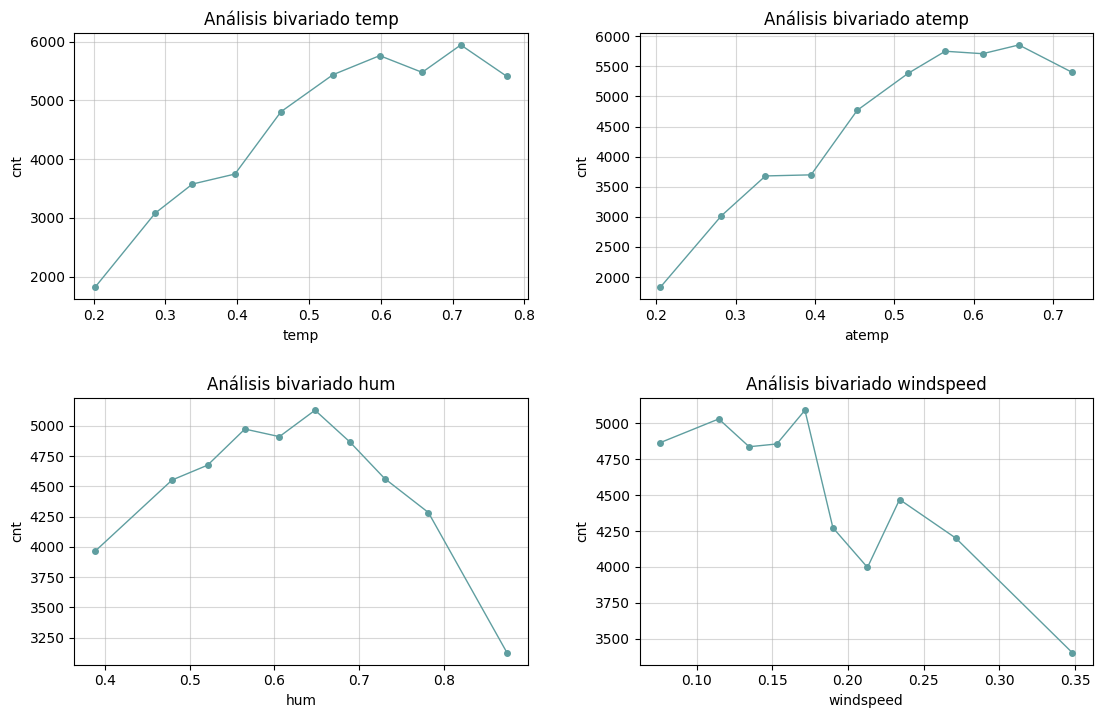

In [30]:
numericas = ['temp', 'atemp', 'hum', 'windspeed']

df_bivariado = df.copy()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(pad=5)

for i, ax in enumerate(axes.flat):
    df_bivariado[f'{numericas[i]}_bins'] = pd.qcut(df_bivariado[numericas[i]], q=10, labels=False) + 1
    grouped_data = df_bivariado.groupby(f'{numericas[i]}_bins').mean()
    
    ax.plot(grouped_data[numericas[i]], grouped_data['cnt'], marker='o', color='cadetblue', lw=1, markersize=4)
    ax.set_title(f'Análisis bivariado {numericas[i]}')
    ax.set_xlabel(numericas[i])
    ax.set_ylabel('cnt')
    ax.grid(alpha=0.5)

plt.show()

+ Ninguna de las variables parece tener una relación lineal fuerte con el número de bicicletas.
+ La variable `hum` parece tener una relación cuadrática, por lo que, se hará una prueba elevando al cuadrado y tratar de ajustar una parábola.
+ Las variables `temp` y `atemp` parecen ser las colas izquierdas y `windspeed` la cola derechade una parábola. Por lo tanto, aunque no sea tan clara una relación cuadrática, se hará una prueba elevando al cuadrado las variables

## Modelos de prueba

In [31]:
target = 'cnt'
X = df.copy().drop(columns=[target])
y = df[target]

### Regresión lineal múltiple

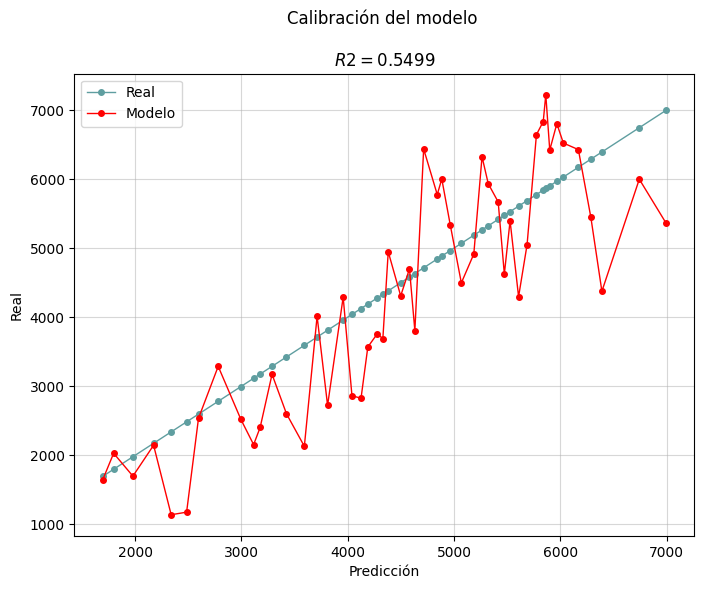

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = linear_model.LinearRegression().fit(X_train, y_train)
predicciones_lineal = model.predict(X_test)
calibracion(predicciones_lineal, y_test, 50)

El modelo tiene un ajuste malo, prácticamente ningun predecido se ajusta con el real. Aunque en todo el modelo hay poca presición, especialmente en los datos mas grandes hay peor ajuste.

### Modelo polinomial de grado 2

#### Aplicar StandardScaler

In [33]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

#### Modelo

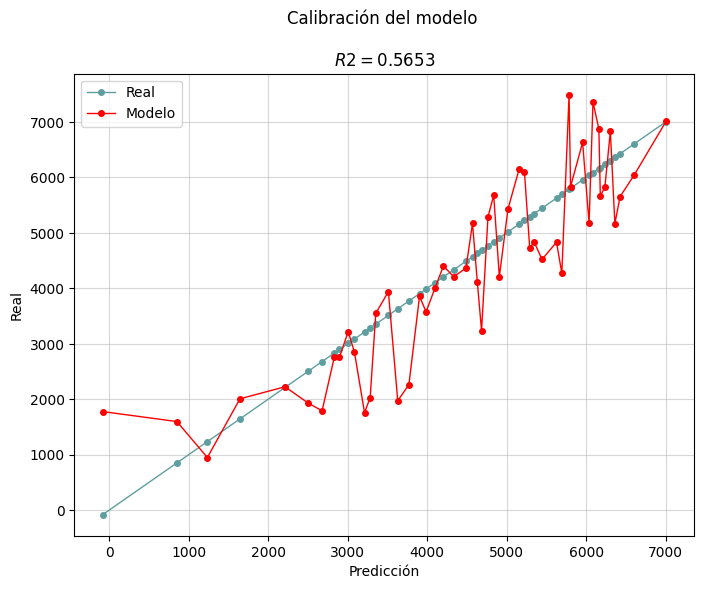

In [34]:
degree = 2

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = linear_model.Lasso().fit(X_train, y_train)
predicciones_poly_2 = model.predict(X_test)

calibracion(predicciones_poly_2, y_test, 50)

Se redujo un poco la variabilidad del modelo, así como tambien se observa en la gráfica que hay un mejor ajuste en los puntos del centro. Ahora hay un mejor ajuste en los datos grandes, pero uno peor en los pequeños. 

### Modelo polinomial de grado 3

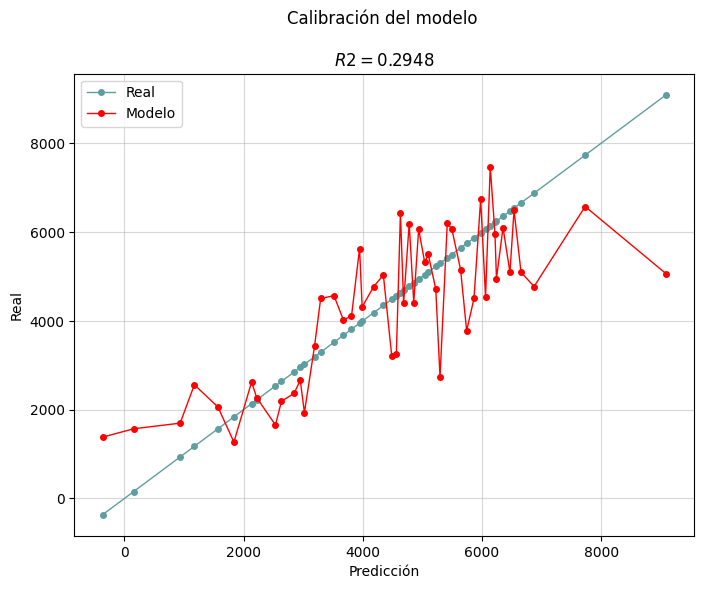

In [35]:
degree = 3

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = linear_model.Lasso().fit(X_train, y_train)
predicciones_poly_3 = model.predict(X_test)

calibracion(predicciones_poly_3, y_test, 50)

El modelo comenzó a memorizar y perdió ajuste.

## Realizar Feature Engeneering

+ Relacionar `temp` con `atemp`.
+ Elevar al cuadrado todas las variables, dado que en el bivariado se observó que podrían ajustarse parábolas.

In [36]:
df_fe = df.copy()

df_fe['temp_atemp'] = df_fe['temp'] / df_fe['atemp']

df_fe['hum_2'] = df_fe['hum']**2
df_fe['temp_2'] = df_fe['temp']**2
df_fe['atemp_2'] = df_fe['atemp']**2
df_fe['windspeed_2'] = df_fe['windspeed']**2

## Modelos despues de Feature Engeneering

In [37]:
target = 'cnt'
X = df_fe.copy().drop(columns=[target])
y = df_fe[target]

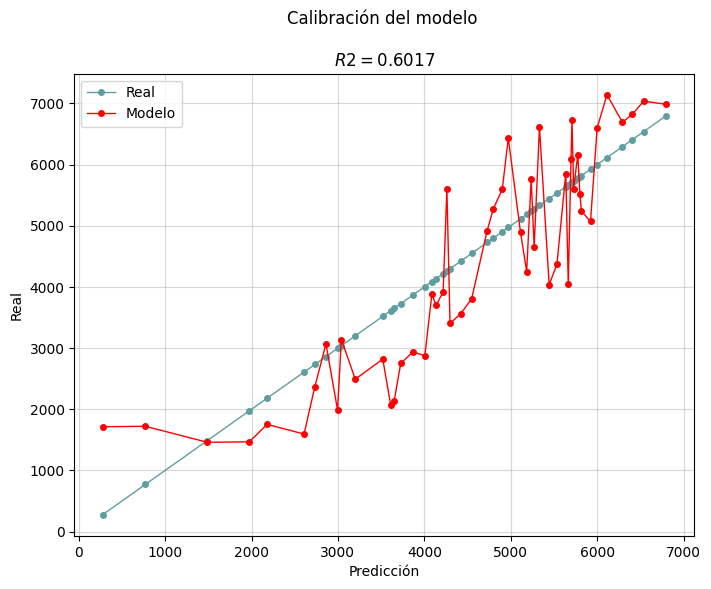

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = linear_model.LinearRegression().fit(X_train, y_train)
predicciones_lineal = model.predict(X_test)
calibracion(predicciones_lineal, y_test, 50)

El R2 del modelo tuvo una mejora significativa con respecto a los modelos pasados. Nuevamente tuvo un mejor ajuste en los datos del centro hacia arriba, mientras que los datos pequeños tuvieron poca precisión.

### Modelo polinomial de grado 2

#### Aplicar StandardScaler

In [39]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

#### Modelo

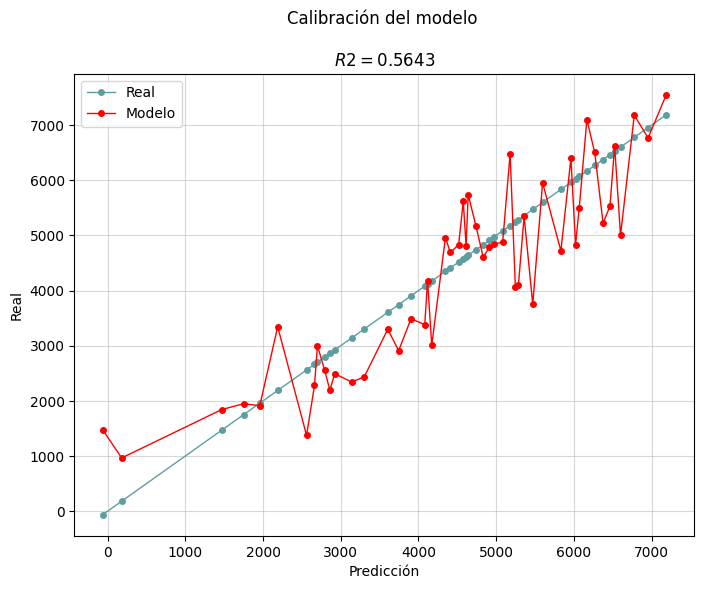

In [40]:
degree = 2

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = linear_model.Lasso().fit(X_train, y_train)
predicciones_poly_2 = model.predict(X_test)

calibracion(predicciones_poly_2, y_test, 50)

Aunque la calibración del modelo no se ve tan mal comparada a la pasada, el R2 bajó, por lo que se descarta.

### Modelo polinomial de grado 3

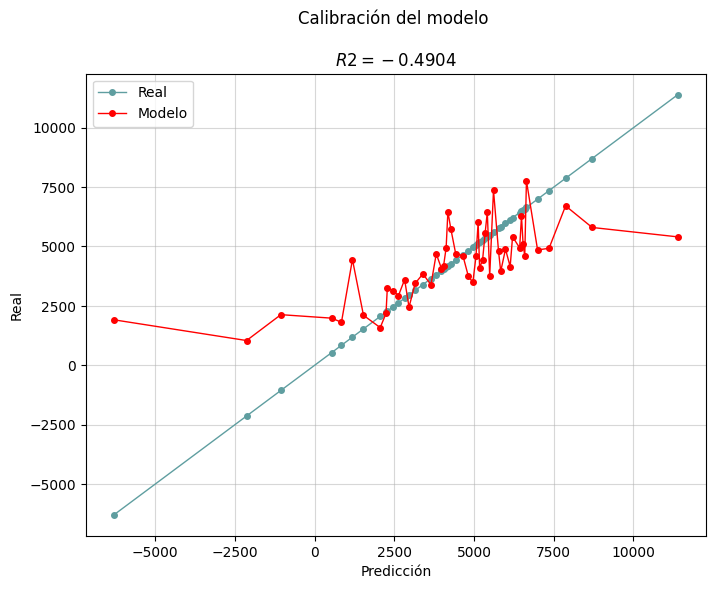

In [41]:
degree = 3

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = linear_model.Lasso().fit(X_train, y_train)
predicciones_poly_3 = model.predict(X_test)

calibracion(predicciones_poly_3, y_test, 50)

Nuevamente el modelo comienza a memorizar y se descarta.

## Modelo Final 

El modelo a utilizar es la regresión lineal múltiple utilizando las columnas del Feature Engeneering.

**************** Resultados del modelo ****************

El R2 del modelo es: 0.6017
El MSE del modelo es: 1597142.1633

El intercepto del modelo es: -17173265772417808.0000

Coeficientes del modelo:


,Variable,Coeficiente
0,holiday,-4.062999e+16
1,workingday,-4.062999e+16
2,temp,7.906790e+04
3,atemp,-5.713258e+04
4,hum,5.549925e+03
5,windspeed,-3.850778e+03
6,season_1,-2.003309e+15
7,season_2,-2.003309e+15
8,season_3,-2.003309e+15
9,season_4,-2.003309e+15




Calibración del modelo:


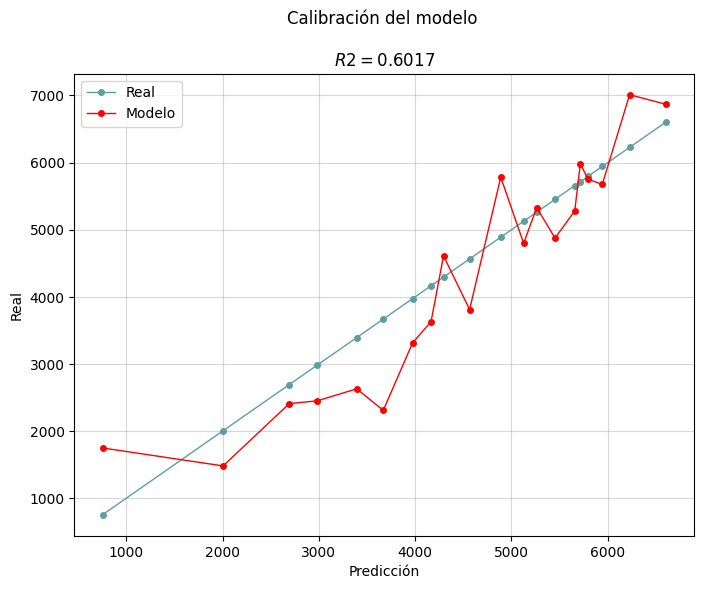

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = linear_model.LinearRegression().fit(X_train, y_train)
predicciones_lineal = model.predict(X_test)
coeficientes = pd.DataFrame({'Variable': X_train.columns, 'Coeficiente': model.coef_})

# Imprimir resultados
print('**************** Resultados del modelo ****************')
print(f'\nEl R2 del modelo es: {r2_score(y_pred=predicciones_lineal, y_true=y_test):.4f}')
print(f'El MSE del modelo es: {mean_squared_error(y_pred=predicciones_lineal, y_true=y_test):.4f}')
print(f'\nEl intercepto del modelo es: {model.intercept_:.4f}')
print("\nCoeficientes del modelo:")
display(coeficientes)
print('\n\nCalibración del modelo:')
calibracion(predicciones_lineal, y_test, 20)

## Conclusiones

+ Antes del feature engeneering, el mejor modelo fue un polinomial de grado 2. Sin embargo, despues de crear nuevas variables, el modelo comenzó a memorizar en los polinomios empeorando su ajuste.
+ Se logró mejorar el ajuste en los grandes y del centro, sin embargo, hubo poca precisión en los datos pequeños.

# AB testing para holiday y workingday

In [43]:
df = pd.read_csv('day.csv')
df = df[['workingday', 'holiday', 'cnt']]
df.head()

,workingday,holiday,cnt
0,0,0,985
1,0,0,801
2,1,0,1349
3,1,0,1562
4,1,0,1600


In [44]:
print(f"Promedio de bicicletas rentadas en un día de trabajo: {df[df['workingday'] == 1]['cnt'].mean():.0f}")
print(f"Promedio de bicicletas rentadas en un día de vaciaciones: {df[df['holiday'] == 1]['cnt'].mean():.0f}")

Promedio de bicicletas rentadas en un día de trabajo: 4585
Promedio de bicicletas rentadas en un día de vaciaciones: 3735


## AB testing a mano

En este AB testing se quiere probar si hay alguna diferencia significativa en la cantidad de bicicletas rentadas en un día dado que es un día de vacaciones o de trabajo.

En este caso, nuestra variable control son los días de trabajo dado es lo que normalmente sucede, y los días de vacaciones son nuestro test, dado que son los casos especiales.

In [ ]:
def AB_test(test, control):
    # Mu
    mu_test = test.mean()
    mu_control = control.mean()
    
    # SE
    se_test = test.sem()
    se_control = control.sem()
    
    # Differences
    mu_diff = mu_control - mu_test
    se_diff = np.sqrt((test.var() / len(test) + (control.var() / len(control))))
    
    # Z score and p value 
    z = mu_diff / se_diff
    p_value = stats.norm.cdf(z)
    
    # Resultados
    print(f'Variable test entre {(mu_test - 2*se_test):.4f} y {(mu_test + 2*se_test):.4f}')
    print(f'Variable control entre {(mu_control - 2*se_control):.4f} y {(mu_control + 2*se_control):.4f}')
    print(f'Intervalo de confianza del efecto causal {mu_diff - 2*se_diff} y {mu_diff + 2*se_diff}')
    print(f'Z score: {z:.4f}')
    print(f'P value: {p_value:.4f}')

### AB para holiday

In [45]:
test = df[df['holiday'] != 1]['cnt']
control = df[df['holiday'] == 1]['cnt']

AB_test(test, control)

Variable test entre 4382.3150 y 4671.8934
Variable control entre 2817.0225 y 4652.9775
Intervalo de confianza del efecto causal -1721.4300998833712 y 137.22164917914574
Z score: -1.7047
P value: 0.0441


### AB para workingday

In [46]:
test = df[df['workingday'] != 1]['cnt']
control = df[df['workingday'] == 1]['cnt']

AB_test(test, control)

Variable test entre 4060.1269 y 4600.2108
Variable control entre 4416.8094 y 4752.8306
Intervalo de confianza del efecto causal -63.3900582003555 y 572.6923958626924
Z score: 1.6014
P value: 0.9454


### Interpretación de los resultados:

+ El P-Value para holiday al ser menor a 5% hace que podamos aceptar que es significante para la cantidad rentada de bicicletas.

+ El P-Value para workingday es casi 1, lo que indica que en efecto no es significativa para la cantidad rentada de bicicletas.

## AB testing con la paquetería de statsmodel

In [47]:
result = smf.ols('cnt ~ holiday + workingday', data=df).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4389.6857,133.413,32.903,0.000,4127.766,4651.605
holiday,-654.6857,442.480,-1.480,0.139,-1523.375,214.004
workingday,195.1343,158.980,1.227,0.220,-116.979,507.248


+ Los resultados son diferentes que haciendolos a mano.

+ Ambas variables tienen un P-Value que indica que las variables no son significativas para la predicción de la cantidad de bicicletas rentadas en la regresión lineal, por lo que deberían descartarse a la hora de predecir la cantidad de bicicletas rentadas.